<a href="https://colab.research.google.com/github/kelangray/Neural-ODEs/blob/main/cnfs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from torchdyn.core import NeuralODE
    from torchdyn.models import CNF
    from torchdyn.nn import Augmenter
    from torchdyn.datasets import *
    from torchdyn.utils import *
except ImportError:
    !pip install torchdyn
    from torchdyn.core import NeuralODE
    from torchdyn.models import CNF
    from torchdyn.nn import Augmenter
    from torchdyn.datasets import *
    from torchdyn.utils import *

import matplotlib.pyplot as plt
%matplotlib inline

#Continuous Normalizing Flows

In this notebook we will discuss Conntinuous Normalizing Flows (CNFs), which provide a way to find continuous maps between two probability distributions. We will also see that by introducing a kinetic energy penalization we can encourage straight-line trajectories, reducing computational overhead.

##Mathematical Background
Continuous Normalizing Flows solve the Initial Value Problem (IVP):

$$
\begin{cases}
\frac{dX}{dt}(t) = f_{\theta}(t, X(t)) \\
X(0) \sim \rho_0,
\end{cases}
$$
where $\rho_0 $ is an unknown distribution.

**Goal**: Learn $f_\theta$ such that $X(1)$ is a standard normal distribution.

If $\rho: [0, 1] \times \mathbb{R}^n \rightarrow \mathbb{R}$ is the pushforward of $\rho_0$ under the flow of (IVP), then it satisfies the instantanious change of variables (ICOV) formula

$$\log(\rho(x, t)) = \log(\rho_0(X(0))) - \int_0^t \nabla \cdot f_\theta(s, X(s)) \, ds .$$

We then solve the augmented problem:

$$
\begin{cases}
\frac{d}{dt}
\begin{pmatrix}
X(t) \\
Y(t)
\end{pmatrix}
=  \begin{pmatrix} f_{\theta}(t, X(t)) \\ \nabla \cdot f_\theta(t, X(t)) \end{pmatrix}\\
X(0) \sim \rho_0, Y(0) = 0,
\end{cases}
$$
and perform a Maximum Likelihood estimation

$$\min_\theta \mathbb{E}_{\rho_0} [-\rho(x, 1)]$$

using the instantanious change of variables formula.

## References

The original paper for CNFs:
- Chen, Ricky TQ, Rubanova, Yulia, Bettencourt, Jesse, and Duvenaud, David K.
  [Neural ordinary differential equations](https://arxiv.org/abs/1806.07366).
  *Advances in Neural Information Processing Systems*, 31, 2018.

Regularization of CNFs is explored in:
- Finlay, Chris, Jacobsen, Jörn-Henrik, Nurbekyan, Levon, and Oberman, Adam M.
  [How to train your neural ODE](https://arxiv.org/abs/2002.02798).
  *arXiv preprint arXiv:2002.02798*, 2020.

To solve the neural ODEs above, we use the Torchdyn library:
- Poli, Michael, Massaroli, Stefano, Yamashita, Atsushi, Asama, Hajime, Park, Jinkyoo, and Ermon, Stefano.
  [TorchDyn: Implicit Models and Neural Numerical Methods in PyTorch](https://physical-reasoning.github.io/assets/pdf/papers/03.pdf).
  *arXiv preprint arXiv:2004.07679*, 2020.


##Vizualize the dataset

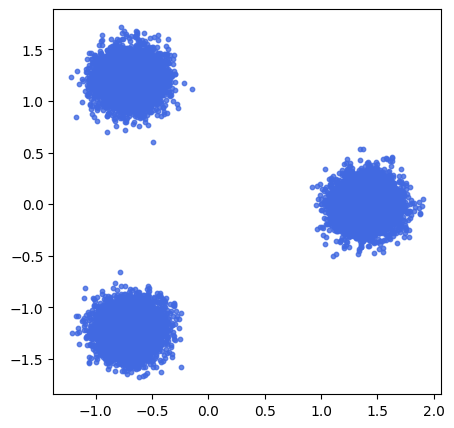

In [2]:
data = ToyDataset()
n_samples = 1 << 14
n_gaussians = 3

X, yn = data.generate(n_samples // n_gaussians, 'gaussians', n_gaussians=3, std_gaussians=0.5, radius=5, dim=2)
X = (X - X.mean())/X.std()

plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c='royalblue', s=10, alpha=0.8)

In [3]:
import torch
import torch.utils.data as data

device = torch.device("cpu")
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn).long().to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=1024, shuffle=True)

##Define CNF

In [4]:
#Parameterized vector field
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 2),
    )

def autograd_div(x_out, x_in,):
    div = 0.
    for i in range(x_in.shape[1]):
        div += torch.autograd.grad(x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True)[0][:, i]
    return div

class CNF(nn.Module):
    def __init__(self, net, autograd_div):
        super().__init__()
        self.net = net
        self.autograd_div = autograd_div

    def forward(self, x):
        with torch.set_grad_enabled(True):
            x_in = x[:,1:].requires_grad_(True) # first dimension reserved to divergence propagation
            x_out = self.net(x_in)
            div = self.autograd_div(x_out, x_in)

        return torch.cat([-div[:, None], x_out], 1) #Augment state: [-div, x]

cnf = CNF(f, autograd_div)
nde = NeuralODE(cnf, solver='dopri5', sensitivity='adjoint', atol=1e-4, rtol=1e-4)

model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1),
                      nde).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


##Train CNF

In [5]:
import pytorch_lightning as pl

from torch.distributions import MultivariateNormal
prior = MultivariateNormal(torch.zeros(2).to(device), 0.3*torch.eye(2).to(device)) #Normal Dist. to flow into

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iters = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        self.iters += 1
        x, _ = batch
        t, traj = self.model(x)

        x_out = traj[1, :,1:]
        divs = traj[1, :,0]

        logprob = prior.log_prob(x_out).to(x) - divs #Instantanious Change of Variables
        loss = -torch.mean(logprob) #MLE
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=2e-3, weight_decay=1e-5)

    def train_dataloader(self):
        return trainloader

learn = Learner(model)
trainer = pl.Trainer(max_epochs=25, gradient_clip_val=1.0)
trainer.fit(learn);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 8.6 K  | train
---------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


##Evolution of Probability Densities

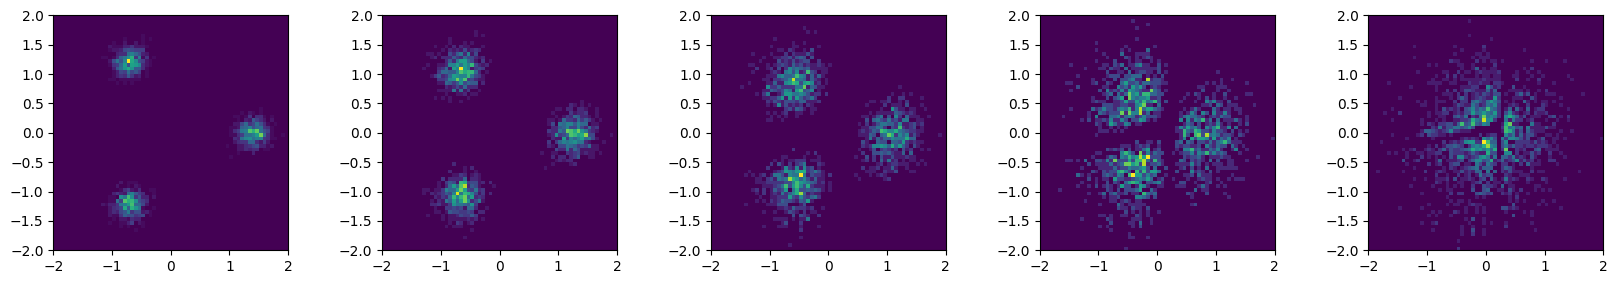

In [6]:
sample_indices = torch.randint(0, X.shape[0], (2000,)).numpy()

#Trajectories
t_span=torch.linspace(0, 1, 100)
traj = model[1].trajectory(Augmenter(1, 1)(X[sample_indices]), t_span=t_span).detach().cpu()
traj = traj[:, :, 1:]  # Remove divergence

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.subplots_adjust(wspace=0.4)

indices = np.linspace(0, t_span.shape[0]-1, num=5, dtype=int)
for i in range(len(indices)):
    idx = indices[i]
    ax = axes[i]
    h = ax.hist2d(
        traj[idx, :, 0].cpu().numpy(),
        traj[idx, :, 1].cpu().numpy(),
        bins=64,
        cmap="viridis",
        density=True,
        range=[[-2, 2], [-2, 2]]
    )
    ax.set_aspect('equal')
plt.show()

#Regularized CNFs

Now consider the ODE

$$
\begin{cases}
\frac{d}{dt}
\begin{pmatrix}
X(t) \\
Y(t) \\
Z(t)
\end{pmatrix}
=  \begin{pmatrix} f_{\theta}(t, X(t)) \\ \nabla \cdot f_\theta(t, X(t))  \\ \|f_\theta (t, X(t))\|^2\end{pmatrix}\\
X(0) \sim \rho_0, Y(0) = Z(0) = 0,
\end{cases}
$$
and minimize the **regularized objective**:

$$\min_\theta \mathbb{E}_{\rho_0} [-\rho(x, 1) + \lambda Z(1)],$$

where $\lambda > 0$ is a hyperparameter to be tuned.
$Z(1)$ penalises the kinetic energy of the vector field $f$, encouraging straight-line trajectories and can thus improve convergence rates.

Let us implement this formulation.

In [7]:
class RCNF(nn.Module):
    def __init__(self, net, autograd_div):
        super().__init__()
        self.net = net
        self.aut                                                                                                                                                                                                                ograd_div = autograd_div

    def forward(self, x):
        with torch.set_grad_enabled(True):
            x_in = x[:,2:].requires_grad_(True) # first dimension reserved to divergence propagation
            x_out = self.net(x_in)

            traj = self.autograd_div(x_out, x_in)
            norms = torch.norm(x_out, p=2, dim=1, keepdim=True) # |f|^2

            x_div = torch.cat([-traj[:, None], x_out], 1) + 0*x[:, 1:] # `+ 0*x` has the only purpose of connecting x[:, 0

        return torch.cat([norms, x_div], 1)

regularized_cnf = RCNF(f, autograd_div)
nde = NeuralODE(regularized_cnf, solver='dopri5', sensitivity='adjoint', atol=1e-4, rtol=1e-4)

regularized_model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=2),
                      nde).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [8]:
l=0.5 #Kinetic energy regularization hyperparameter

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iters = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        self.iters += 1
        x, _ = batch
        t, traj = self.model(x)

        ke = traj[1, :, 0] #Kinetic energy penalization
        div = traj[1, :, 1]
        x_out = traj[1, :, 2:]

        logprob =  prior.log_prob(x_out).to(x) - div  # Instantanious Change of Variables
        loss = torch.mean(-logprob + l*ke) #Regularized loss
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=2e-3, weight_decay=1e-5)

    def train_dataloader(self):
        return trainloader

learn = Learner(regularized_model)
trainer = pl.Trainer(max_epochs=25, gradient_clip_val=1.0)
trainer.fit(learn);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 8.6 K  | train
---------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


##Vizualize Sample Trajectories



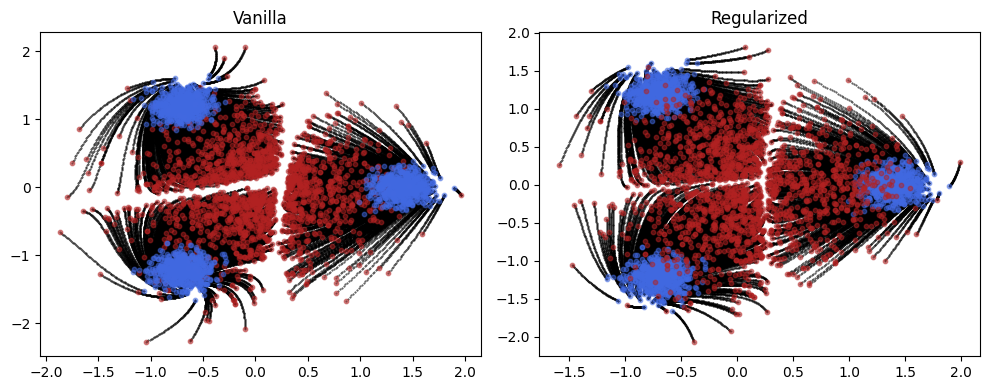

In [9]:
t_span=torch.linspace(0, 1, 100)
regularized_traj = regularized_model[1].trajectory(Augmenter(1, 2)(X[sample_indices]), t_span=t_span).detach().cpu()
regularized_traj = regularized_traj[:, :, 2:]  # Remove kinetic energy and divergence

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#Vanilla
for i in range(t_span.shape[0]):
    axes[0].scatter(traj[i, :, 0], traj[i, :, 1], s=0.2, alpha=0.8, c='black') #Vanilla trajectories
    axes[1].scatter(regularized_traj[i, :, 0], regularized_traj[i, :, 1], s=0.2, alpha=0.8, c='black') #Regularized trajectories

axes[0].scatter(traj[-1, :, 0], traj[-1, :, 1], s=10, alpha=0.5, c='firebrick')
axes[0].scatter(traj[0, :, 0], traj[0, :, 1], s=10, alpha=0.5, c='royalblue')
axes[1].scatter(regularized_traj[0, :, 0], regularized_traj[0, :, 1], s=10, alpha=0.5, c='royalblue')
axes[1].scatter(regularized_traj[-1, :, 0], regularized_traj[-1, :, 1], s=10, alpha=0.5, c='firebrick')

axes[0].set_title('Vanilla')
axes[1].set_title('Regularized')

plt.tight_layout()
plt.show()